# **GPU configration**


In [1]:
!nvidia-smi

Tue Mar  5 13:58:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **ALL THE NECESSARY INSTALLATIONS**

In [ ]:
!pip install --upgrade astrapy
!pip install langchain_community
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1.0 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off
!pip install auto-gptq
!pip install fastapi
!pip install uvicorn
!pip install pickle5
!pip install scikit-learn
!pip install requests
!pip install pypi-json
!pip install pyngrok
!pip install nest-asyncio

**ALL THE NECESSARY PACKAGES AND LIBRARIES**

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline
from langchain.memory import (
    ChatMessageHistory,
    ConversationBufferMemory,
    ConversationBufferWindowMemory,
    ConversationSummaryBufferMemory,
    VectorStoreRetrieverMemory,
)
from langchain.chains.question_answering import load_qa_chain
from langchain_community.vectorstores import AstraDB
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

from fastapi import FastAPI
import pickle
import json
import uvicorn
from pyngrok import ngrok
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio

In [6]:
from google.colab import userdata
astra_db_api_endpoint=userdata.get('astra_db_api_endpoint')
astra_db_application_token=userdata.get('astra_db_application_token')


# **INITIALIZING FASTAPI APP**

In [ ]:
app = FastAPI()

**SETTING UP CORS**

In [ ]:
origins = ["*"]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

**AUTOGPT FOR PREVIOUS CUDA VERSION**

In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu122-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu122-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:

!sudo apt-get install poppler-utils

# **BUFFER MEMORY INITIALISATION**

In [7]:
memory = ConversationBufferMemory(memory_key="chat_history", input_key="question")

# **LOADING PDF INTO LOCAL DIRECTORY UNDER "PDFS"**

In [ ]:
!mkdir pdfs

In [ ]:
!gdown --id 1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr -O pdfs/tesla-earnings-report.pdf
!gdown --id 1Xc890jrQvCExAkryVWAttsv1DBLdVefN -O pdfs/nvidia-earnings-report.pdf
!gdown --id 1Epz-SQ3idPpoz75GlTzzomag8gplzLv8 -O pdfs/meta-earnings-report.pdf


In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
loader = WebBaseLoader("https://www.stockgro.club/faq/")
data = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
website_texts = text_splitter.split_documents(data)
print(website_texts)

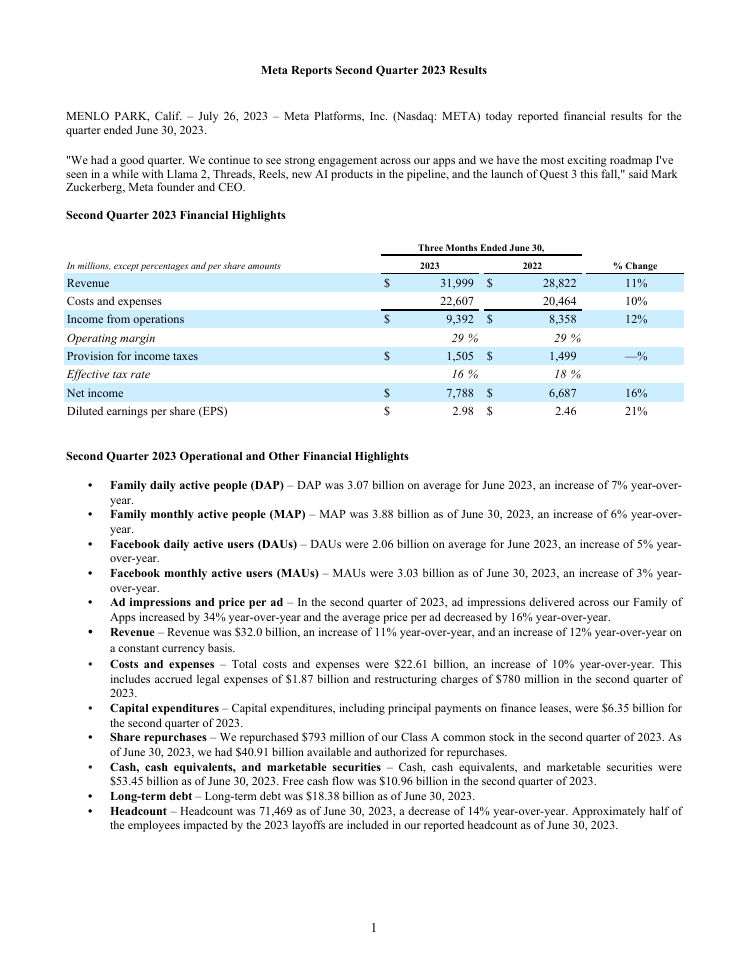

In [ ]:
meta_images = convert_from_path("pdfs/meta-earnings-report.pdf", dpi=88)
meta_images[0]


# **DOWNLOADING EMBEDDINGS MODEL**

In [ ]:
embeddings = HuggingFaceInstructEmbeddings( model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE} )

# **UPLOADING PDFS IN KNOWLEDGE BASE (AstraDB Vector Database)**

In [ ]:
def get_pdf_text_from_folder(folder_path):
    loader = PyPDFDirectoryLoader(folder_path)
    docs = loader.load()
    return docs


def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
    texts = text_splitter.split_documents(text)
    return texts

def get_vector_store(text_chunks):

    #embeddings = HuggingFaceInstructEmbeddings( model_name="sentence-transformers/all-MiniLM-L6-v2")
    embeddings = HuggingFaceInstructEmbeddings( model_name="hkunlp/instructor-large")
    vstore = AstraDB(
        embedding=embeddings,
        collection_name="pdfdata",
        token=astra_db_application_token,
        api_endpoint=astra_db_api_endpoint
    )
    vstore.add_documents(text_chunks)
    # vector_store = FAISS.from_texts(text_chunks, embedding=embeddings)
    # vector_store.save_local("faiss_index")


loader = WebBaseLoader("https://www.stockgro.club/faq/")
data = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
website_texts = text_splitter.split_documents(data)
get_vector_store(website_texts)
pdf_folder_path = "pdfs"
raw_text = get_pdf_text_from_folder(pdf_folder_path)
text_chunks = get_text_chunks(raw_text)
get_vector_store(text_chunks)

# **INITIALIZING ASTRA DB DATASTAX VECTOR DB**

In [ ]:

vstore = AstraDB(
    embedding=embeddings,
    collection_name="pdfdata",
    token=astra_db_application_token,
    api_endpoint=astra_db_api_endpoint
)


In [ ]:
vstore.add_documents(texts)
vstore.add_documents(website_texts)

In [ ]:
 relevant_docs = vstore.similarity_search("what is Stockgro?", astra_db_application_token="AstraCS:caMHvgsIrkHpjTCAoyhRnsRK:945bdbb46d23f616e73a5a3675bcbfa6353152446500bec0e2ab1185119736f3",search_kwargs={"k": 2})

In [ ]:
print(relevant_docs)

In [ ]:
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

# **DOWNLOADING LARGE LANGAUGE MODEL**

In [ ]:

model_name_or_path = "TheBloke/Llama-2-7B-chat-GPTQ"
model_basename = "model"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

**FINE_TUNED MODEL NOT RECOMMENDED FOR RAG**

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib einops
!pip install -q git+https://github.com/huggingface/peft.git

import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "Ansh154/llama-2-Stockgro"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    load_in_8bit=True,
    device_map="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

**DEFAULT META LLAMA 2 PROPMT FROM HUGGINFACE MODEL CARD**

In [12]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()


**FOR STREAMING TEXT FROM LLM**

In [13]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

**SETTING UP TEXT PIPELINE**

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

In [15]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})


**SYSTEM PROPMT**

In [16]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. and include not more than 1 logical short follow up question that can be asked by the user, include it in the answer in the end saying you can also ask these follow up questions :"

template = generate_prompt(
    """

Context : {context}
Conversation_history : {chat_history}
Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [21]:
prompt = PromptTemplate(template=template, input_variables=["chat_history","context", "question"])

In [ ]:
retriever = vstore.as_retriever(search_kwargs={"k": 3})

# **MAIN FUNCTION**

In [ ]:
def generate_answer(user_question):
  relevant_docs = vstore.similarity_search(user_question, astra_db_application_token="AstraCS:caMHvgsIrkHpjTCAoyhRnsRK:945bdbb46d23f616e73a5a3675bcbfa6353152446500bec0e2ab1185119736f3",search_kwargs={"k": 2})
  chain = load_qa_chain(llm, chain_type="stuff",memory=memory, prompt=prompt)
  response = chain({"input_documents": relevant_docs, "question": user_question}, return_only_outputs=True)
  print(chain.memory.buffer)
  return response


In [ ]:
result = generate_answer("What is the revenue for Meta during 2023?")


In [ ]:
print(result)

# **SETTING UP API ENDPOINT**

In [ ]:
from fastapi import Request
@app.post('/answer/')
async def get_answer1(request: Request):
  question = await request.json()
  user_question = question.get("question", "")
  result =await generate_answer(user_question)
  return {"answer":result['output_text']}

**DEBUGGER FOR UTF-8 ERROR**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# **FOR STARTING SERVER**

In [ ]:
import os
os.environ["NGROK_AUTH_TOKEN"] = "2clej493G1s6VnuKLG2o05CvOoa_Xco8eB85k5CjJDzhmHhx"
!ngrok authtoken 2clej493G1s6VnuKLG2o05CvOoa_Xco8eB85k5CjJDzhmHhx
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

# **TERMINAL STOCKBOT**

**setting terminal wrapper**

In [17]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }

  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [18]:
def generate_answer(user_question):
  relevant_docs = vstore.similarity_search(user_question, astra_db_application_token="AstraCS:caMHvgsIrkHpjTCAoyhRnsRK:945bdbb46d23f616e73a5a3675bcbfa6353152446500bec0e2ab1185119736f3",search_kwargs={"k": 2})
  chain = load_qa_chain(llm, chain_type="stuff",memory=memory, prompt=prompt)
  print("StockBot : ")
  response = chain({"input_documents": relevant_docs, "question": user_question}, return_only_outputs=True)

In [23]:
def welcome_message():
    print("\n")
    print("-" * 50)
    print("\n")
    print("Welcome to StockBot, your personal AI-powered investment assistant StockGro. We believe in making investments social, and StockBot is here to revolutionize the way you interact with financial information.")
    print("\n")
    print("-" * 50)
    print("\n")


def ask_question():
    return input("USER: ").strip()

def main():
    welcome_message()
    conversation_active = True
    while conversation_active:
        user_question = ask_question()
        if user_question:
            if user_question.lower() == "end":
                conversation_active = False
                print("\n")
                print("-" * 50)
                print("\n")
                print("Thank you for using StockBot. Goodbye!")
            else:
                print("-" * 50)
                response = generate_answer(user_question)
                print("-" * 50)
                print("\n")
        else:
            print("Please enter a question.")

if __name__ == "__main__":
    main()




--------------------------------------------------


Welcome to StockBot, your personal AI-powered investment assistant StockGro. We believe in making investments social, and StockBot is here to revolutionize the way you interact with financial information.


--------------------------------------------------


USER: If i am a beginner in investing, which stock is better to invest in Meta, tesla or Nvidia?
--------------------------------------------------
StockBot : 
 Based on the information provided, it seems like you are interested in investing in stocks but are unsure which one to choose, especially between Meta, Tesla, and Nvidia. As a beginner, it's essential to understand the basics of investing and the companies you are considering investing in. Here's some general advice:
1. Research and Understand the Companies: Before investing in any stock, research the company's financials, products, services, competition, market trends, and growth potential. Look for companies with str

# **SETTING UP STREAMING**

# **-----------------------------------------------------------------------------**

In [ ]:
result = qa_chain( "Which company is more profitable during 2023 Meta, Nvidia or Tesla and why?" )

 I cannot determine which company is more profitable during 2023 between Meta, Nvidia, and Tesla based on the information provided. The passage only discusses Nvidia's financial condition and results of operations but does not provide any information about Meta or Tesla's financial performance during 2023. Additionally, it is important to note that profitability can be influenced by various factors such as market conditions, product offerings, competition, and economic conditions, among others. Therefore, without access to the financial statements of all three companies, it is not possible to accurately compare their profitability during 2023.


In [ ]:
result = qa_chain( "if i am a beginner in investing, what is the safest stock to buy, tesla, nvidia or meta and why?" )

 I cannot provide personalized investment advice, nor can I guarantee the safety of any particular stock. However, based on the information provided, NVIDIA Corporation might be a safer stock to consider for beginners compared to Tesla, Inc. (TSLA) and Meta Platforms, Inc. (META). Here's why:

1. Revenue stability: NVIDIA has demonstrated a stable revenue stream over the years, primarily due to its strong presence in the GPU market and increasing demand for its AI and data center solutions. In contrast, Tesla's revenue is heavily dependent on the volatile automotive industry, while Meta's primary source of income is advertising, which can be affected by economic fluctuations.
2. Profitability: NVIDIA has consistently reported net income and maintained profitability over the past few years, whereas Tesla and Meta have struggled with profitability, particularly in recent years.
3. Cash reserves: NVIDIA has a significant cash reserve of $7.23 billion available for share repurchases until 

In [ ]:
result = qa_chain( "Give me a table which shows stats for tesla" )

 Based on the provided financial statements for Tesla, Inc., here are some key statistics:

| Category | Assets | Liabilities | Equity |
| --- | --- | --- |
| Total Current Assets | $43,875 million | $16,253 million | $90,591 million |
| Operating Lease Vehicles, Net | $5,935 million | $5,035 million | $5,489 million |
| Solar Energy Systems, Net | $5,365 million | $5,035 million | $5,489 million |
| Property, Plant, and Equipment, Net | $26,389 million | $23,548 million | $21,548 million |
| Intangible Assets, Net | $202 million | $184 million | $184 million |
| Goodwill | $263 million | $263 million | $263 million |
| Other Non-Current Assets | $5,026 million | $4,193 million | $4,193 million |
| Total Liabilities | $16,253 million | $16,253 million | $16,253 million |
| Stockholders' Equity | $90,591 million | $82,338 million | $82,338 million |

These statistics provide information about Tesla's balance sheet as of June 30, 2023, including its total assets, liabilities, and equity.